# Baseline Modelling

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer

from sentence_transformers import SentenceTransformer


In [2]:
import os
import sys
from pathlib import Path

path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/saideepbunny/Projects/Application_Ranking_System


## Reading the data

In [3]:
df = pd.read_csv(f"{path}/data/synthetic_data/synthetic_data_v1.csv")
df

,job_data,resume_data,label
0,Master Scheduler\nBaltimore Aircoil Company (B...,# *John Miller*\n\n**Professional Summary**\n\...,Complete Mismatch
1,Master Scheduler\nBaltimore Aircoil Company (B...,# James Casey\n\n## Professional Summary\n\nHi...,Underwhelming
2,Master Scheduler\nBaltimore Aircoil Company (B...,# Rachel Vargas\n\n## Professional Summary\n\n...,Good Fit
3,Master Scheduler\nBaltimore Aircoil Company (B...,# Susan Bradley\n\n**Professional Summary**\n\...,Overqualified
4,Master Technician\nCompany / Location Informat...,# Sean Johnson\n\n## Professional Summary\n\nD...,Complete Mismatch
...,...,...,...
5995,Account Executive Digital Sales\nOverview\nSal...,# Todd Walters\n\n**Professional Summary**\n\n...,Overqualified
5996,"Account Executive, Industrial Equipment\nWith ...",**DOUGLAS BLAKE**\n\n**Professional Summary**\...,Complete Mismatch
5997,"Account Executive, Industrial Equipment\nWith ...",# Kyle Villegas\n\n## Professional Summary\n\n...,Underwhelming
5998,"Account Executive, Industrial Equipment\nWith ...",# Charles Preston\n\n**Professional Summary**\...,Good Fit


In [4]:
print("Number of rows in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])

Number of rows in the dataset: 6000
Number of columns in the dataset: 3


In [5]:
df['label'].value_counts()

label
Complete Mismatch    1518
Underwhelming        1499
Good Fit             1498
Overqualified        1485
Name: count, dtype: int64

## Data preprocessing

In [6]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add("overqualified")
stop_words.add("underqualified")
stop_words.add("mismatch")
stop_words.add("good")
print(stop_words)

{'while', "wasn't", 'don', "he's", 'once', 'other', 'whom', "hadn't", 'has', 'doesn', "we're", 'until', 'which', "haven't", "it'd", 'himself', 'the', 'out', 'if', "mightn't", 'ours', 'y', 'yours', 'she', 'couldn', 'our', "he'd", 's', "they'll", 'my', 'then', 'does', 'of', 'do', 'who', "isn't", 'some', 'more', "we've", "hasn't", 'will', 'after', 'each', 'hadn', 'no', 'above', 'can', 'was', 'weren', 'shan', "shan't", 'up', 'd', 'below', 'there', 'not', "we'd", 'have', "i'll", 'both', 'underqualified', 'those', 'such', 'than', 'in', 'aren', 'themselves', 'mustn', 're', "that'll", 'your', 'about', 've', "it's", 'we', 'mismatch', 'or', 'through', 'where', 'o', 'with', "couldn't", 'i', 'itself', 'a', 'her', 'just', 'on', 'he', 'them', 'should', 'is', 'yourselves', 'doing', 'are', "doesn't", 'isn', "he'll", "you'll", 'didn', 'when', 'be', "she's", "you're", "i'm", 'had', 'into', 'wouldn', 'again', 'its', 'off', "she'd", 'ain', 'shouldn', 'him', 'were', "they've", 'they', 'over', 'before', 'me

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saideepbunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove unwanted symbols except %, $, /, and .
    text = re.sub(r"[^a-z0-9\s%$/.-]", "", text)

    # Preserve hyphens only when followed by a number (e.g., 2005-2010, 2010-present)
    text = re.sub(r"-(?!\d)", "", text)  # Remove hyphens not followed by a digit

    # Preserve GPA-like formats (e.g., 3.8/4.0)
    text = re.sub(r"(?<!\d)/|/(?!\d)", " ", text)  # Remove '/' unless between numbers

    # Remove periods (".") if they are immediately after a word but not numbers (e.g., "good." → "good", but keep 3.8)
    text = re.sub(r"\b(\w+)\.(?!\d)", r"\1", text)

    # Remove newline characters
    text = text.replace("\n", " ").replace("\r", " ")

    # Remove any show less and show more texts
    text = text.replace("show less", "").replace("show more", "")
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    text = " ".join(word for word in text.split() if word not in stop_words)

    return text

In [8]:
df['job_data_preprocessed'] = df['job_data'].apply(preprocess_text)
df['resume_data_preprocessed'] = df['resume_data'].apply(preprocess_text)

In [9]:
print(df.iloc[1]['job_data'])
print("\n******************************************************\n")
print(df.iloc[1]['job_data_preprocessed'])

Master Scheduler
Baltimore Aircoil Company (BAC), an Amsted Industry, is a proudly employee-owned, equal-opportunity company who is committed to upholding a diverse, inclusive culture that thrives on teamwork and a spirit of enterprise. We are the global leader in sustainable solutions for evaporative cooling, thermal storage, and heat transfer equipment with headquarters located in Jessup, Maryland and manufacturing located in Madera, CA, Milford, DE and Dayton, TN. The Master Scheduler, BAC Dayton is a key member of the Dayton, Tennessee Supply Chain Team, to include Baltimore Aircoil Company (BAC) and Coil Design operations. If you want to make an impact, have a sense of belonging and a desire to grow. Every reason to join us begins with YOU!
POSITION PURPOSE
The Master Scheduler, BAC Dayton is a key member of the Dayton, Tennessee Supply Chain Team, to include Baltimore Aircoil Company (BAC) and Coil Design operations. Role manages the daily plant supply chain operations to maximiz

In [10]:
print(df.iloc[1]['resume_data'])
print("\n******************************************************\n")
print(df.iloc[1]['resume_data_preprocessed'])

# James Casey

## Professional Summary

Highly motivated and detail-oriented professional with experience in operations and supply chain management. Proven track record of managing production control, manufacturing scheduling, and safety initiatives. Seeking to leverage my skills and experience to contribute to a dynamic team as a Master Scheduler.

## Skills

Operations, Supply Chain, MRP systems, Master scheduling, Production control, Manufacturing scheduling, Safety, Quality, Operations performance, Ownership, Urgency, Sales orders, Master schedule, Supply needs, Staffing needs, Load leveling, Bottleneck scheduling, Operations input, Output reporting, Sales & operations planning, Communication, Teamwork, Leadership, Capacity management, Layered manufacturing, Organization, Interpersonal skills, Analytical skills, Follow-up skills, Initiative, Attention to detail, Microsoft Office, Excel, Lean Manufacturing Methodologies, JIT concepts, Business, Operations Management, Accounting

## 

## Modelling: Sentence Embeddings

### Utility functions

In [11]:
def cross_validation_scores(model, X, y, n_splits=5):
    # Define k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
    # Print results
    print(f"Cross-validation scores: {scores}")
    print(f"Mean accuracy: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    
    
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Displays a confusion matrix using seaborn heatmap.

    Parameters:
    y_true : list or array
        True labels.
    y_pred : list or array
        Predicted labels.
    labels : list, optional
        Class labels for the confusion matrix.
    title : str, optional
        Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


def chunk_text(text, max_length=512, overlap=50):
    """
    Splits text into overlapping chunks.
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_length - overlap):
        chunk = " ".join(words[i:i+max_length])
        chunks.append(chunk)
        if i + max_length >= len(words):
            break
    return chunks

def get_text_embedding(text, model):
    """
    Converts large text into embeddings using chunking + mean pooling.
    """
    chunks = chunk_text(text)
    embeddings = model.encode(chunks, convert_to_numpy=True)  # Get embeddings
    return np.mean(embeddings, axis=0)  # Aggregate embeddings using mean pooling

### Generating embeddings

In [12]:
embedding_df = pd.DataFrame()

# Load a Transformer model
embedding_model = SentenceTransformer('all-mpnet-base-v2') #768 dimension vector space


In [13]:
# Compute embeddings
jd_data = df['job_data_preprocessed'].apply(lambda x: get_text_embedding(x, embedding_model))
jd_df = pd.DataFrame(jd_data.tolist(), index=df.index, columns = [f"jd_{i+1}" for i in range(len(jd_data.tolist()[0]))])

resume_data = df['resume_data_preprocessed'].apply(lambda x: get_text_embedding(x, embedding_model))
resume_df = pd.DataFrame(resume_data.tolist(), index=df.index, columns = [f"r_{i+1}" for i in range(len(resume_data.tolist()[0]))])


embedding_df = pd.concat([jd_df, resume_df], axis=1)
embedding_df

,jd_1,jd_2,jd_3,jd_4,jd_5,jd_6,jd_7,jd_8,jd_9,jd_10,...,r_759,r_760,r_761,r_762,r_763,r_764,r_765,r_766,r_767,r_768
0,0.009577,0.006245,-0.033296,0.011508,0.010937,0.031040,0.027990,0.012026,-0.036721,-0.018761,...,-0.028887,0.009025,-0.027261,0.019367,-0.019691,-0.069188,-0.014478,0.005515,0.055554,-0.023629
1,0.009577,0.006245,-0.033296,0.011508,0.010937,0.031040,0.027990,0.012026,-0.036721,-0.018761,...,0.008974,0.045976,0.007253,0.016612,-0.024913,-0.034840,0.007707,-0.011463,0.010438,-0.044241
2,0.009577,0.006245,-0.033296,0.011508,0.010937,0.031040,0.027990,0.012026,-0.036721,-0.018761,...,0.032656,0.017854,0.029796,0.008518,-0.022498,0.002091,-0.012543,-0.000042,-0.022655,-0.057506
3,0.009577,0.006245,-0.033296,0.011508,0.010937,0.031040,0.027990,0.012026,-0.036721,-0.018761,...,-0.010185,0.040874,0.018428,0.005628,-0.027361,-0.047506,-0.007277,0.004484,-0.026369,-0.061704
4,-0.010420,-0.033459,-0.032495,-0.045843,-0.010880,0.029193,0.024162,0.022396,-0.011753,-0.018466,...,-0.005320,0.018147,-0.031401,0.031785,-0.030024,-0.030181,-0.022365,0.003535,0.085359,-0.009603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.077558,0.065484,-0.029228,-0.041669,0.024160,0.008118,0.029876,-0.000238,-0.026611,-0.068392,...,-0.014344,0.016800,-0.027923,0.032383,-0.027306,-0.016949,-0.027304,0.016285,0.002847,-0.026341
5996,0.041520,0.087291,-0.027078,-0.021404,0.037023,0.017331,-0.016720,0.002071,-0.025603,-0.056898,...,-0.029710,0.018241,-0.053562,0.040958,-0.026269,0.021377,0.000972,0.012668,0.056699,-0.043082
5997,0.041520,0.087291,-0.027078,-0.021404,0.037023,0.017331,-0.016720,0.002071,-0.025603,-0.056898,...,-0.028676,0.010334,-0.025344,0.026858,-0.019152,-0.019665,-0.020374,0.004647,0.031211,-0.032664
5998,0.041520,0.087291,-0.027078,-0.021404,0.037023,0.017331,-0.016720,0.002071,-0.025603,-0.056898,...,-0.061163,0.036026,-0.016092,0.026519,-0.010434,0.006242,-0.010167,-0.002530,-0.027904,-0.041730


### Defining X and y

In [14]:
# Stack embeddings horizontally
X = embedding_df.copy()
y = df['label']

### Train Test split

In [15]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (4800, 1536)
Test data shape:  (1200, 1536)


### DecisionTreeClassifier

In [16]:
model = DecisionTreeClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train, y_train, n_splits=5)

Cross-validation scores: [0.521875   0.521875   0.49375    0.54583333 0.52604167]
Mean accuracy: 0.5219
Standard deviation: 0.0166


In [17]:
# Train model on full training set
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.74      0.74      0.74       304
         Good Fit       0.38      0.35      0.36       299
    Overqualified       0.43      0.46      0.45       297
    Underwhelming       0.56      0.58      0.57       300

         accuracy                           0.53      1200
        macro avg       0.53      0.53      0.53      1200
     weighted avg       0.53      0.53      0.53      1200


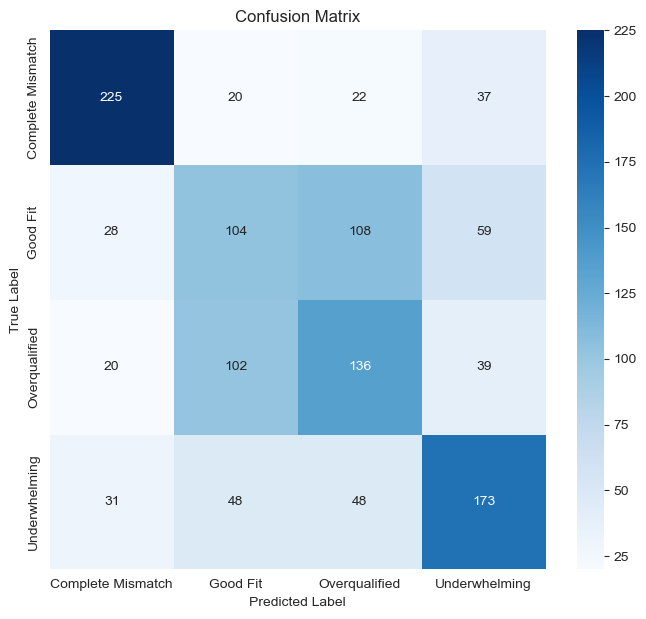

In [18]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

### RandomForestClassifier

In [19]:
model = RandomForestClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train, y_train, n_splits=5)

Cross-validation scores: [0.65520833 0.63645833 0.65625    0.67708333 0.66979167]
Mean accuracy: 0.6590
Standard deviation: 0.0140


In [20]:
# Train model on full training set
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.95      0.92      0.94       304
         Good Fit       0.37      0.36      0.36       299
    Overqualified       0.46      0.49      0.48       297
    Underwhelming       0.77      0.75      0.76       300

         accuracy                           0.63      1200
        macro avg       0.64      0.63      0.63      1200
     weighted avg       0.64      0.63      0.63      1200


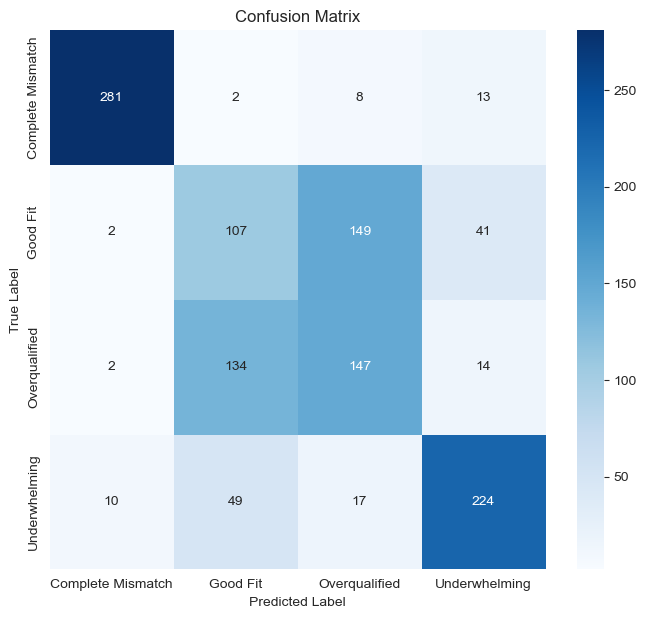

In [21]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

### XGBClassifier : Multi class classification

In [22]:
X = embedding_df.copy()
y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":1, "Good Fit":2, "Overqualified":3})

/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_24026/3337498069.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":1, "Good Fit":2, "Overqualified":3})


In [23]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (4800, 1536)
Test data shape:  (1200, 1536)


In [24]:
model = XGBClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train, y_train, n_splits=5)

Cross-validation scores: [0.78645833 0.79479167 0.790625   0.76041667 0.77291667]
Mean accuracy: 0.7810
Standard deviation: 0.0127


In [25]:
# Train model on full training set
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       304
           1       0.88      0.84      0.86       300
           2       0.61      0.67      0.63       299
           3       0.67      0.67      0.67       297

    accuracy                           0.77      1200
   macro avg       0.78      0.77      0.77      1200
weighted avg       0.78      0.77      0.77      1200


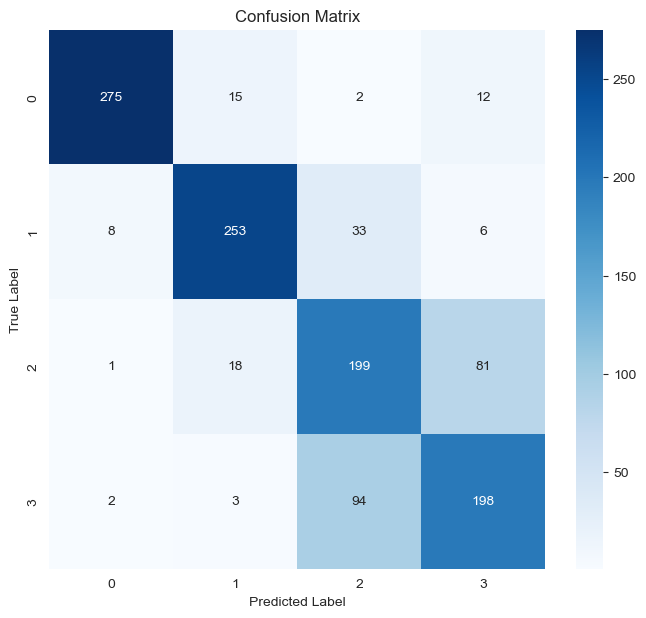

In [26]:
plot_confusion_matrix(y_test, y_pred, [0, 1, 2, 3])

### XGBClassifier : Binary Classification

- Complete Mismatch and Underwhelming are bad fits (0)
- Good fit and Overqualified are good fits (1)

In [27]:
X = embedding_df.copy()
y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":0, "Good Fit":1, "Overqualified":1})

/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_24026/2897412205.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":0, "Good Fit":1, "Overqualified":1})


In [28]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (4800, 1536)
Test data shape:  (1200, 1536)


In [29]:
model = XGBClassifier(random_state=42)  # Example model
cross_validation_scores(model, X_train, y_train, n_splits=5)

Cross-validation scores: [0.93645833 0.93645833 0.95729167 0.91979167 0.94166667]
Mean accuracy: 0.9383
Standard deviation: 0.0120


In [30]:
# Train model on full training set
model.fit(X_train, y_train)

# Evaluate on test set
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       603
           1       0.94      0.94      0.94       597

    accuracy                           0.94      1200
   macro avg       0.94      0.94      0.94      1200
weighted avg       0.94      0.94      0.94      1200


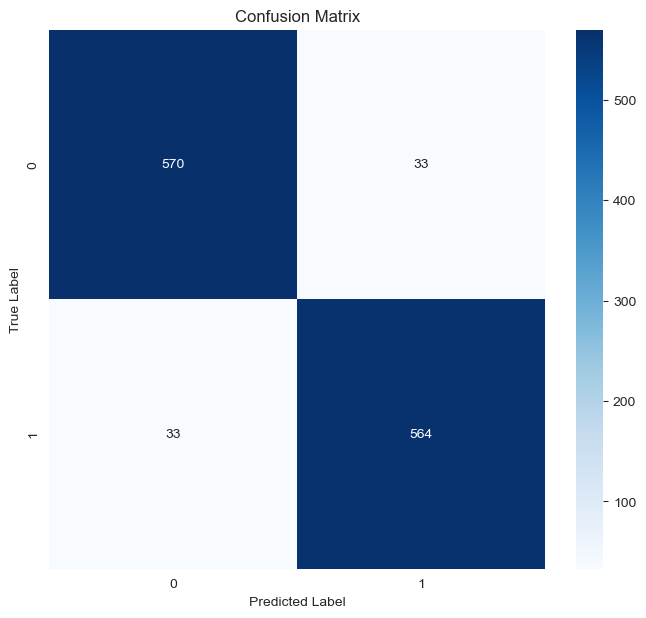

In [31]:
plot_confusion_matrix(y_test, y_pred, [0, 1])